# <center> Project 2 - Neural Language Models for NLP </center>

**Student Names:** Varun Jain (21963986) and Cunjun Yin (22249435) <br>
**Due Date** 24th October 2021

In [1]:
import pandas as pd
import numpy as np
import re
import string
import gensim
import time
import json


import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.corpora import Dictionary
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

import multiprocessing as mp
from spellchecker import SpellChecker

import torch
import torch.nn as nn
import torch.optim as optim
import math
from argparse import Namespace

from torch.utils.data import Dataset, DataLoader
from collections import Counter
from tqdm import tqdm_notebook
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import codecs

# Init

In [2]:
if not nltk.find('corpora/wordnet'):
     nltk.download('wordnet')
porter_stemmer  = PorterStemmer()
lemmatizer      = WordNetLemmatizer()
regex_tokenizer = nltk.tokenize.RegexpTokenizer(r"\w+")
spell  = SpellChecker()
one_hot_vectorizer = CountVectorizer(binary=True)
args = Namespace(
    # Data and Path hyper parameters
    degree_injury_file="./data/degreeinjury.csv",
    injury_bodyparts_file="./data/injurybodyparts.csv",
    NER_file="./data/ner.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.h5",
    save_dir="model_storage/document_classification",
    # Model hyper parameters
    glove_filepath='./Glove/glove.6B.200d.txt', 
    use_glove=True,
    embedding_size=150, 
    # Training hyper parameter
    window_size=5,
    val_proportion=0.1,
    test_proportion=0.2,
    learning_rate = 0.001,
    seed=666,
    dropout_p=0.1, 
    batch_size=256, 
    num_epochs=100, 
    early_stopping_criteria=5, 
    # Runtime option
    cuda=True, 
    catch_keyboard_interrupt=True, 
    reload_from_files=False,
    expand_filepaths_to_save_dir=True
)

np.random.seed(666)
torch.manual_seed(666)
if args.cuda:
    torch.cuda.manual_seed_all(666)

# Function

In [3]:
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"): 
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

In [4]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

In [5]:
def update_train_state(args, model, train_state):
    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

In [6]:
def compute_accuracy(y_pred, y_target):
    y_target = y_target.cpu()
    y_pred_indices = (torch.sigmoid(y_pred)>0.5).cpu().long()#.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

In [7]:
def make_embedding_matrix(glove_filepath, words):
    word_to_idx, glove_embeddings = load_glove_from_file(glove_filepath)
    embedding_size = glove_embeddings.shape[1]
    
    final_embeddings = np.zeros((len(words), embedding_size))

    for i, word in enumerate(words):
        if word in word_to_idx:
            final_embeddings[i, :] = glove_embeddings[word_to_idx[word]]
        else:
            embedding_i = torch.ones(1, embedding_size)
            torch.nn.init.xavier_uniform_(embedding_i)
            final_embeddings[i, :] = embedding_i

    return final_embeddings, embedding_size

In [8]:
def load_glove_from_file(glove_filepath):
    word_to_index = {}
    embeddings = []
    with open(glove_filepath, encoding="utf8") as fp:
        for index, line in enumerate(fp):
            line = line.split(" ") # each line: word num1 num2 ...
            word_to_index[line[0]] = index # word = line[0] 
            embedding_i = np.array([float(val) for val in line[1:]])
            embeddings.append(embedding_i)
    return word_to_index, np.stack(embeddings)

In [9]:
def clean_text(text):
    txt = ''
    txt = txt.strip()
    txt = re.sub(r"([.,!?])", r" \1 ", txt)
    for word in tokenize(text):
        # The EE is short hand on employee
        if word=='ee' or word == 'EE':
            txt += ' employee '
        elif word in string.punctuation:
            txt = txt + ' ' +word
        elif len(word)>2:
            word = spell.correction(word)
            txt = txt + ' ' + word.lower().strip()
    txt = re.sub(r"[^a-zA-Z.,!?]+", r" ", txt)
    return txt.strip()

In [10]:
# def tokenize(text):
#     return nltk.word_tokenize(text)

# def stem(words, df=False):
#     stemmed_words=[porter_stemmer.stem(word) for word in words]
#     if df:
#         return pd.DataFrame({'original': words,'stemmed': stemmed_words})
#     return stemmed_words

In [11]:
# def get_wordnet_pos(tag):
#     if tag.startswith('J'):
#         return nltk.corpus.wordnet.ADJ
#     elif tag.startswith('V'):
#         return nltk.corpus.wordnet.VERB
#     elif tag.startswith('N'):
#         return nltk.corpus.wordnet.NOUN
#     elif tag.startswith('R'):
#         return nltk.corpus.wordnet.ADV
#     else:
#         return None

In [12]:
# def lemmatize(words, df=False):
#     lemmatized_words=[]
#     tagged_sent = nltk.pos_tag(words)
    
#     for tag in tagged_sent:
#         wordnet_pos = get_wordnet_pos(tag[1]) or nltk.corpus.wordnet.NOUN
#         if wordnet_pos is None:
#             spell.correction(lemmatized_words.append(lemmatizer.lemmatize(tag[0])))
#         else:
#             spell.correction(lemmatized_words.append(lemmatizer.lemmatize(tag[0], pos=wordnet_pos)))
    
#     if df:
#         return pd.DataFrame({'original': words,'lemmatized': lemmatized_words})
#     return lemmatized_words

# def lemmatize_word(word):
#     tagged_sent = nltk.pos_tag([word])
#     wordnet_pos = get_wordnet_pos(tagged_sent[0][1]) or nltk.corpus.wordnet.NOUN
#     if wordnet_pos is None:
#         return lemmatizer.lemmatize(tagged_sent[0][0])
#     else:
#         return lemmatizer.lemmatize(tagged_sent[0][0], pos=wordnet_pos)


In [13]:
# def SK_TFIDF_stopwords(corpus, vectorizer):
#     vectorizer.fit(corpus)
#     X = vectorizer.transform(corpus)
#     return vectorizer.stop_words_, X

# def get_words(texts):
#     words = []
#     for text in texts:
#         words+=regex_tokenizer.tokenize(text)
#     return np.asarray(words).reshape(-1, 1)

In [14]:
def OHE_2D(sent, sparse=False):
    enc = OneHotEncoder(handle_unknown='ignore', sparse=sparse)
    words=[]
    for w in sent.values:
        words += w
    X = enc.fit(np.array(words).reshape(-1,1))
    
    # Round up to without unit digit
    ohe = sent.apply(lambda x: enc.transform(np.array(x).reshape(-1,1)))
    maxwords = max([len(x) for x in ohe])
    maxwords = math.ceil(maxwords/10)*10
    dim = len(ohe[0][0])
    print('Vector length:          ', dim, '\nMaximum number of words:', maxwords)

    return [np.concatenate((x, np.zeros((maxwords - len(x), dim))), axis=0) for x in ohe]


In [15]:
def OHE_1D(sent):
    corpus = [' '.join(x) for x in sent.values]
    print(corpus[0])
    ohe = CountVectorizer(binary=True)
    return pd.DataFrame(ohe.fit_transform(corpus).todense(), columns=ohe.get_feature_names())


In [16]:
# def spell_check(words):
#     return [spell.correction(word) for word in words]

# def remove_stopwords(words, stopwords):
#     return [w for w in words if w not in stopwords]

In [17]:
# def split_save(data, path, test=0.2, valid= 0.1, stratify=True):
#     if stratify:
#         train, test  = train_test_split(data,  test_size=test, random_state=666, shuffle=True, stratify=data['target'])
#         train, valid = train_test_split(train, test_size=valid, random_state=666, shuffle=True, stratify=train['target'])
#     else:
#         train, test  = train_test_split(data,  test_size=test, random_state=666, shuffle=True)
#         train, valid = train_test_split(train, test_size=valid, random_state=666, shuffle=True)
#     train['split'] = 'train'
#     test['split']  = 'test'
#     valid['split'] = 'val'
#     pd.concat([train, valid, test]).to_csv(path, index=False)

In [18]:
#Store the training vs validation loss and accuracy values
def plot_graph(args):
    return {'epoch_index': [],
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': []}

In [19]:
#plot the training vs validation loss and accuracy
def graph(lst, length,dimension,train, validation,y_axis_label,title):
    plt.figure(figsize=(20,7))
    x_axis = list(range(0,length,dimension))
    plt.plot(x_axis, lst[train],'-o')
    plt.plot(x_axis, lst[validation],'-o')
    plt.xlabel('epoch')
    plt.ylabel(y_axis_label)
    plt.legend(['Train','Valid'])
    plt.title('Train vs Valid' + ' ' + title)
    plt.show()

# Task 1: Binary Document Classification

In [20]:
args = Namespace(
    # Data and Path hyper parameters
    degree_injury_file="./data/degreeinjury.csv",
    vectorizer_file="degreeinjury-vectorizer.json",
    # Model hyper parameters
    glove_filepath='./Glove/glove.6B.200d.txt', 
    use_glove=True,
    embedding_size=150, 
    model_state_file="model.h5",
    # Training hyper parameter
    window_size=5,
    val_proportion=0.1,
    test_proportion=0.2,
    learning_rate = 0.001,
    seed=666,
    dropout_p=0.1, 
    batch_size=256, 
    num_epochs=100, 
    early_stopping_criteria=5, 
    # Runtime option
    cuda=True, 
    catch_keyboard_interrupt=True, 
    reload_from_files=False,
    expand_filepaths_to_save_dir=True
) 

In [21]:
class OHEVocabulary(object):
    """Class to process text and extract Vocabulary for mapping"""
    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx
        self._idx_to_token = {idx: token 
                                for token, idx in self._token_to_idx.items()}
        self._add_unk = add_unk
        self._unk_token = unk_token
        self.unk_index = 1
        if add_unk:
            self.unk_index = self.add_token(unk_token)
    def to_serializable(self):
        return {'token_to_idx': self._token_to_idx, 'add_unk': self._add_unk, 'unk_token': self._unk_token}
    @classmethod
    
    def from_serializable(cls, contents):
        return cls(**contents)
    
    def add_token(self, token):
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    
    def lookup_token(self, token):
        if self._add_unk:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]
        
    def lookup_index(self, index):
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]
    
    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)
    
    def __len__(self):
        return len(self._token_to_idx)

In [22]:
class OHESequenceVocabulary(OHEVocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(OHESequenceVocabulary, self).__init__(token_to_idx)

        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)

    def to_serializable(self):
        contents = super(OHESequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self._unk_token,
                         'mask_token': self._mask_token,
                         'begin_seq_token': self._begin_seq_token,
                         'end_seq_token': self._end_seq_token})
        return contents

    def lookup_token(self, token):
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

In [23]:
class OHEVectorizer(object):
    def __init__(self, NARRATIVE_vocab, target_vocab):
        self.NARRATIVE_vocab = NARRATIVE_vocab
        self.target_vocab = target_vocab

    def vectorize(self, NARRATIVE):
        one_hot = np.zeros(len(self.NARRATIVE_vocab), dtype=np.float32)
        for token in NARRATIVE.split(" "):
            if token not in string.punctuation:
                one_hot[self.NARRATIVE_vocab.lookup_token(token)] = 1
        return one_hot

    @classmethod
    def from_dataframe(cls, df, cutoff=15):
        target_vocab = OHEVocabulary()        
        for target in sorted(set(df.target)):
            target_vocab.add_token(target)

        word_counts = Counter()
        for NARRATIVE in df.NARRATIVE:
            for token in NARRATIVE.split(" "):
                if token not in string.punctuation:
                    word_counts[token] += 1
        
        NARRATIVE_vocab = OHESequenceVocabulary()
        for word, word_count in word_counts.items():
            if word_count >= cutoff:
                NARRATIVE_vocab.add_token(word)
        
        return cls(NARRATIVE_vocab, target_vocab)

    @classmethod
    def from_serializable(cls, contents):
        NARRATIVE_vocab =   OHESequenceVocabulary.from_serializable(contents['NARRATIVE_vocab'])
        target_vocab =  OHEVocabulary.from_serializable(contents['target_vocab'])

        return cls(NARRATIVE_vocab=NARRATIVE_vocab, target_vocab=target_vocab)

    def to_serializable(self):
        return {'NARRATIVE_vocab': self.NARRATIVE_vocab.to_serializable(),
                'target_vocab': self.target_vocab.to_serializable()}


In [24]:
class OHEDataset(Dataset):
    def __init__(self, df, vectorizer):
        self.df = df
        self._vectorizer = vectorizer
        
        # +1 if only using begin_seq, +2 if using both begin and end seq tokens
        measure_len = lambda context: len(context.split(" "))
        self._max_seq_length = max(map(measure_len, df.NARRATIVE)) + 2
        
        self.train_df = self.df[self.df.split=='train']
        self.train_size = len(self.train_df)
        self.val_df = self.df[self.df.split=='val']
        self.validation_size = len(self.val_df)
        self.test_df = self.df[self.df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),'val': (self.val_df, self.validation_size),'test': (self.test_df, self.test_size)}
        self.set_split('train')

    @classmethod
    def load_dataset_and_make_vectorizer(cls, csv):
        df = pd.read_csv(csv)
        return cls(df, OHEVectorizer.from_dataframe(df))
    
    @classmethod
    def load_dataset_and_load_vectorizer(cls, news_csv, vectorizer_filepath):
        df = pd.read_csv(news_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(news_csv, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        with open(vectorizer_filepath) as fp:
            return NameVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        return self._vectorizer

    def set_split(self, split="train"):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        row = self._target_df.iloc[index]
        NARRATIVE_vector = self._vectorizer.vectorize(row.NARRATIVE)
        target_index = self._vectorizer.target_vocab.lookup_token(row.target)-1
        return {'x_data': NARRATIVE_vector,'y_target': target_index}

    def get_num_batches(self, batch_size):
        return len(self) // batch_size

In [25]:
class OHEClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim=1):
        super(OHEClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.relu1 = nn.ReLU()
        
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.relu2 = nn.ReLU()
        
        self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.relu3 = nn.ReLU()
        
        self.fc4 = nn.Linear(hidden_dims[2], output_dim) 
    
    def forward(self, x, apply_sigmoid=False):
        out = self.fc1(x)
        out = self.relu1(out)
        
        out = self.fc2(out)
        out = self.relu2(out)
        
        out = self.fc3(out)
        out = self.relu3(out)
        
        out = self.fc4(out)
        
        if apply_sigmoid:
            out = torch.sigmoid(out)
        return out.squeeze()

In [26]:
train_state = make_train_state(args)
if not torch.cuda.is_available():
    args.cuda = False
args.device = torch.device("cuda" if args.cuda else "cpu")

# dataset and vectorizer
dataset = OHEDataset.load_dataset_and_make_vectorizer(args.degree_injury_file)
vectorizer = dataset.get_vectorizer()
# model
classifier = OHEClassifier(input_dim=len(vectorizer.NARRATIVE_vocab), hidden_dims=[256, 256, 128])
classifier = classifier.to(args.device)
# loss and optimizer
loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.0001)
train_state = make_train_state(args)
if not torch.cuda.is_available():
    args.cuda = False
args.device = torch.device("cuda" if args.cuda else "cpu")

In [27]:
len(vectorizer.NARRATIVE_vocab)

501

In [28]:
best_val  = {
    'epoch': 0,
    'model_state_dict': 0,
    'optimizer_state_dict': 0,
    'loss': 0,
    'acc':0
}

loss_acc_plot = plot_graph(args)
for epoch_index in range(150):
    train_state['epoch_index'] = epoch_index
    # Iterate over training dataset
    # setup: batch generator, set loss and acc to 0, set train mode on
    dataset.set_split('train')
    batch_generator = generate_batches(dataset, batch_size=len(dataset), device=args.device)
    running_loss = 0.0
    running_acc = 0.0
    classifier.train()
    for batch_index, batch_dict in enumerate(batch_generator):
        # the training routine is 5 steps:
        # step 1. zero the gradients
        optimizer.zero_grad()
        # step 2. compute the output
        y_pred = classifier(batch_dict['x_data'].float())
        # step 3. compute the loss
        loss = loss_func(y_pred, batch_dict['y_target'].float())
        loss_batch = loss.item()
        running_loss += (loss_batch-running_loss) / (batch_index + 1)
        # step 4. use loss to produce gradients
        loss.backward()
        # step 5. use optimizer to take gradient step
        optimizer.step()
        # compute the accuracy
        acc_batch = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_batch - running_acc) / (batch_index + 1)

    train_state['train_loss'].append(running_loss)
    train_state['train_acc'].append(running_acc)

    dataset.set_split('val')
    batch_generator = generate_batches(dataset, batch_size=len(dataset), device=args.device)
    running_loss = 0.
    running_acc = 0.
    classifier.eval()

    for batch_index, batch_dict in enumerate(batch_generator):
        # step 1. compute the output
        y_pred = classifier(batch_dict['x_data'].float())
        # step 2. compute the loss
        loss = loss_func(y_pred, batch_dict['y_target'].float())
        loss_batch = loss.item()
        running_loss += (loss_batch - running_loss) / (batch_index + 1)
        # step 3. compute the accuracy
        acc_batch = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_batch - running_acc) / (batch_index + 1)
    train_state['val_loss'].append(running_loss)
    train_state['val_acc'].append(running_acc)
    if(best_val['acc'] < running_acc):
        best_val  = {
            'epoch': epoch_index,
            'model_state_dict': classifier.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': running_loss,
            'acc' : running_acc
        }
    if epoch_index%5 == 0:
        print('Train loss', round(train_state['train_loss'][-1], 4), 'Train acc', round(train_state['train_acc'][-1], 4), 'Val loss', round(train_state['val_loss'][-1], 4), 'Val acc', round(train_state['val_acc'][-1], 4))
        loss_acc_plot['epoch_index'].append(epoch_index)
        loss_acc_plot['val_loss'].append(round(train_state['val_loss'][-1], 4))
        loss_acc_plot['val_acc'].append(round(train_state['val_acc'][-1], 4))
        loss_acc_plot['train_loss'].append(round(train_state['train_loss'][-1], 4))
        loss_acc_plot['train_acc'].append(round(train_state['train_acc'][-1], 4))
torch.save(best_val, "OHE.h5")

Train loss 0.6964 Train acc 44.7939 Val loss 0.6958 Val acc 44.6541
Train loss 0.6949 Train acc 44.7939 Val loss 0.6945 Val acc 44.6541
Train loss 0.6935 Train acc 44.7939 Val loss 0.6932 Val acc 44.6541
Train loss 0.692 Train acc 49.406 Val loss 0.6919 Val acc 52.8302
Train loss 0.6904 Train acc 71.9776 Val loss 0.6905 Val acc 71.6981
Train loss 0.6885 Train acc 67.3655 Val loss 0.689 Val acc 61.6352
Train loss 0.6862 Train acc 63.1726 Val loss 0.6871 Val acc 60.3774
Train loss 0.6832 Train acc 62.8931 Val loss 0.6847 Val acc 60.3774
Train loss 0.6793 Train acc 63.9413 Val loss 0.6816 Val acc 61.0063
Train loss 0.6742 Train acc 65.269 Val loss 0.6777 Val acc 61.6352
Train loss 0.6674 Train acc 67.645 Val loss 0.6727 Val acc 62.2642
Train loss 0.6587 Train acc 70.1607 Val loss 0.6664 Val acc 64.1509
Train loss 0.6474 Train acc 72.1873 Val loss 0.6585 Val acc 67.2956
Train loss 0.6331 Train acc 74.144 Val loss 0.6487 Val acc 67.9245
Train loss 0.6156 Train acc 76.3802 Val loss 0.6372 Va

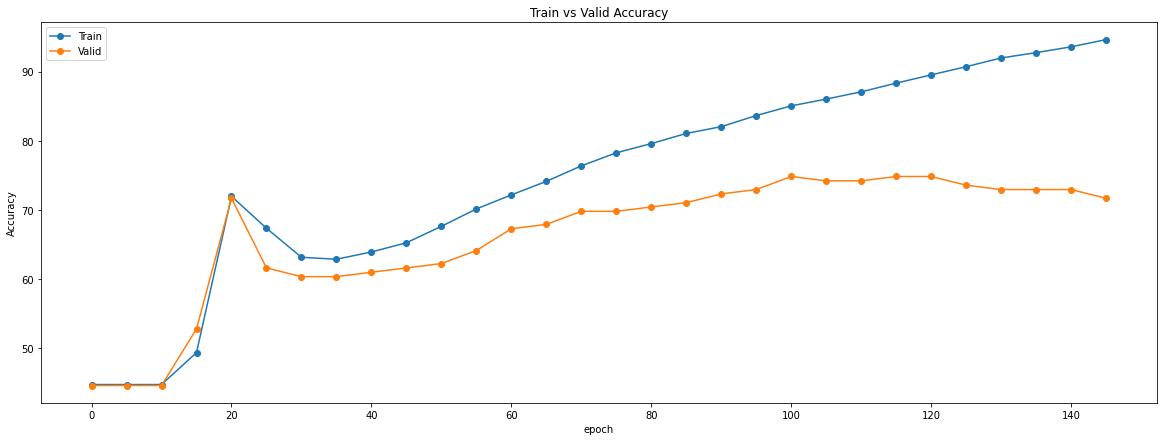

In [29]:
graph(loss_acc_plot, 150,5,'train_acc', 'val_acc','Accuracy','Accuracy')

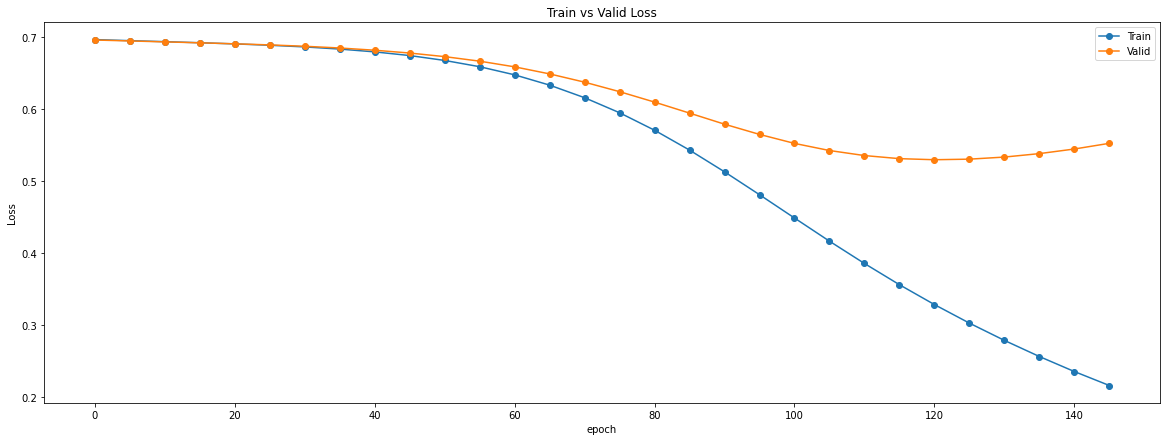

In [30]:
graph(loss_acc_plot, 150,5,'train_loss', 'val_loss','Loss','Loss')

The model seems to be overfitting the data

In [31]:
dataset.set_split('test')
batch_generator = generate_batches(dataset, batch_size=len(dataset),device=args.device)
running_loss = 0.
running_acc = 0.
checkpoint = torch.load("OHE.h5")
classifier.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
classifier.eval()
for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred = classifier(x=batch_dict['x_data'].float())
    y_actual = batch_dict['y_target']
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'].float())
    loss_batch = loss.item()
    running_loss += (loss_batch - running_loss) / (batch_index + 1)
    # compute the accuracy
    acc_batch = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_batch - running_acc) / (batch_index + 1)
train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

In [32]:
print("Test loss: {:.3f}".format(train_state['test_loss']))
print("Test Accuracy: {:.2f}".format(train_state['test_acc']))

Test loss: 0.629
Test Accuracy: 73.62


## Word embedding 

In [33]:
class Vocabulary(object):
    def __init__(self, token_to_idx=None):
        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx
        self._idx_to_token = {idx: token for token, idx in self._token_to_idx.items()}
        
    def to_serializable(self):
        return {'token_to_idx': self._token_to_idx}

    @classmethod
    def from_serializable(cls, contents):
        return cls(**contents)

    def add_token(self, token):
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
            
    def add_many(self, tokens):
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        return self._token_to_idx[token]

    def lookup_index(self, index):
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [34]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)
        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)

    def to_serializable(self):
        contents = super(SequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self._unk_token,
                         'mask_token': self._mask_token,
                         'begin_seq_token': self._begin_seq_token,
                         'end_seq_token': self._end_seq_token})
        return contents

    def lookup_token(self, token):
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

In [35]:
class GloveVectorizer(object):  
    def __init__(self, NARRATIVE_vocab, target_vocab):
        self.NARRATIVE_vocab = NARRATIVE_vocab
        self.target_vocab = target_vocab

    def vectorize(self, NARRATIVE, vector_length=-1):
        indices = [self.NARRATIVE_vocab.begin_seq_index]
        indices.extend(self.NARRATIVE_vocab.lookup_token(token) for token in NARRATIVE.split(" ") if token not in string.punctuation)
        indices.append(self.NARRATIVE_vocab.end_seq_index)

        if vector_length < 0:
            vector_length = len(indices)

        out_vector = np.zeros(vector_length, dtype=np.int64)
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.NARRATIVE_vocab.mask_index

        return out_vector

    @classmethod
    def from_dataframe(cls, df, cutoff=5):
        target_vocab = Vocabulary()        
        for target in sorted(set(df.target)):
            target_vocab.add_token(target)
        
        word_counts = Counter()
        for NARRATIVE in df.NARRATIVE:
            for token in NARRATIVE.split(" "):
                if token not in string.punctuation:
                    word_counts[token] += 1
        
        NARRATIVE_vocab = SequenceVocabulary()
        for word, word_count in word_counts.items():
            if word_count >= cutoff:
                NARRATIVE_vocab.add_token(word)
#             else: 
#                 print(word)
        
        return cls(NARRATIVE_vocab, target_vocab)

    @classmethod
    def from_serializable(cls, contents):
        title_vocab = SequenceVocabulary.from_serializable(contents['NARRATIVE_vocab'])
        category_vocab = Vocabulary.from_serializable(contents['target_vocab'])
        return cls(NARRATIVE_vocab=NARRATIVE_vocab, target_vocab=target_vocab)

    def to_serializable(self):
        return {'NARRATIVE_vocab': self.NARRATIVE_vocab.to_serializable(), 'target_vocab': self.target_vocab.to_serializable()}


In [36]:
class GloveDataset(Dataset):
    def __init__(self, df, vectorizer):
        self.df = df
        self._vectorizer = vectorizer

        # +1 if only using begin_seq, +2 if using both begin and end seq tokens
        measure_len = lambda context: len(context.split(" "))
        self._max_seq_length = max(map(measure_len, df.NARRATIVE)) + 2
        
        self.train_df = self.df[self.df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.df[self.df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.df[self.df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size), 'val': (self.val_df, self.validation_size), 'test': (self.test_df, self.test_size)}
        self.set_split('train')

        # Class weights
        class_counts = df.target.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.target_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)
        
        
    @classmethod
    def load_dataset_and_make_vectorizer(cls, news_csv):
        df = pd.read_csv(news_csv)
        train_df = df[df.split=='train']
        return cls(df, GloveVectorizer.from_dataframe(train_df))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, news_csv, vectorizer_filepath):
        df = pd.read_csv(news_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(news_csv, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        with open(vectorizer_filepath) as fp:
            return NameVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        return self._vectorizer

    def set_split(self, split="train"):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        row = self._target_df.iloc[index]
        NARRATIVE_vector = self._vectorizer.vectorize(row.NARRATIVE, self._max_seq_length)
        target_index = self._vectorizer.target_vocab.lookup_token(row.target) #-1
        return {'x_data': NARRATIVE_vector,'y_target': target_index}

    def get_num_batches(self, batch_size):
        return len(self) // batch_size

### Model 1

In [37]:
class GloveClassifier(nn.Module):
    def __init__(self, embedding_size, num_embeddings, num_channels, hidden_dim, num_classes, dropout_p, pretrained_embeddings=None, padding_idx=0):
        super(GloveClassifier, self).__init__()

        if pretrained_embeddings is None:
            self.emb = nn.Embedding(embedding_dim=embedding_size, num_embeddings=num_embeddings, padding_idx=padding_idx)        
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.emb = nn.Embedding(embedding_dim=embedding_size, num_embeddings=num_embeddings, padding_idx=padding_idx,      _weight=pretrained_embeddings)
            
        self.convnet = nn.Sequential(
            nn.Conv1d(in_channels=embedding_size, out_channels=num_channels[0], kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=num_channels[0], out_channels=num_channels[1], kernel_size=2, stride=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=num_channels[1], out_channels=num_channels[2], kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=num_channels[2], out_channels=num_channels[3], kernel_size=2),
            nn.ReLU()
        )
        #MLP         
        self._dropout_p = dropout_p
        self.fc1 = nn.Linear(num_channels[3], hidden_dim[0])
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.1)
        
        self.fc2 = nn.Linear(hidden_dim[0], hidden_dim[1])
        self.relu2 = nn.ReLU()
        
        self.fc3 = nn.Linear(hidden_dim[1], num_classes)

    def forward(self, x_in, apply_softmax=False):
        # embed and permute so features are channels
        x_embedded = self.emb(x_in).permute(0, 2, 1)
        features = self.convnet(x_embedded)
        # average and remove the extra dimension
        remaining_size = features.size(dim=2)
        features = nn.functional.max_pool1d(features, remaining_size).squeeze(dim=2)
        features = nn.functional.dropout(features, p=self._dropout_p)
        
        out = self.fc1(features)
#         out = nn.functional.dropout(out, p=self._dropout_p)
        out = self.relu1(out)
        out = self.dropout1(out)
        
        out = self.fc2(out)
        out = self.relu2(out)
        
        out = self.fc3(out)

        if apply_softmax:
            out = torch.nn.functional.softmax(out, dim=1)
        return out

In [38]:
def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [39]:
if args.reload_from_files:
    # training from a checkpoint
    dataset = GloveDataset.load_dataset_and_load_vectorizer(args.degree_injury_file, args.vectorizer_file)
else:
    # create dataset and vectorizer
    dataset = GloveDataset.load_dataset_and_make_vectorizer(args.degree_injury_file)
    dataset.save_vectorizer(args.vectorizer_file)
vectorizer = dataset.get_vectorizer()

# Use GloVe or randomly initialized embeddings
if args.use_glove:
    words = vectorizer.NARRATIVE_vocab._token_to_idx.keys()
    embeddings, embedding_size = make_embedding_matrix(glove_filepath=args.glove_filepath, words=words)
    print("Using pre-trained embeddings")
else:
    print("Not using pre-trained embeddings")
    embeddings = None

Using pre-trained embeddings


In [40]:
classifier = GloveClassifier(
    embedding_size=embedding_size, 
    num_embeddings=len(vectorizer.NARRATIVE_vocab),
    num_channels=[128,64,32,32],
    hidden_dim=[32, 16], 
    num_classes=len(vectorizer.target_vocab), 
    dropout_p=0.3,
    pretrained_embeddings=embeddings,
    padding_idx=0
)
if not torch.cuda.is_available():
    args.cuda = False
args.device = torch.device("cuda" if args.cuda else "cpu")

In [41]:
best_val  = {
    'epoch': 0,
    'model_state_dict': 0,
    'optimizer_state_dict': 0,
    'loss': 0,
    'acc':0
}
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
    
loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=0.0001)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.5, patience=1)

train_state = make_train_state(args)
loss_abc = make_train_state(args)
for epoch_index in range(200):
    train_state['epoch_index'] = epoch_index
    # Iterate over training dataset
    # setup: batch generator, set loss and acc to 0, set train mode on
    
    dataset.set_split('train')
    batch_generator = generate_batches(dataset, batch_size=len(dataset), device=args.device)
    running_loss = 0.0
    running_acc = 0.0
    classifier.train()

    for batch_index, batch_dict in enumerate(batch_generator):
        # the training routine is these 5 steps:

        # --------------------------------------
        # step 1. zero the gradients
        optimizer.zero_grad()

        # step 2. compute the output
        y_pred = classifier(batch_dict['x_data'])

        # step 3. compute the loss
        loss = loss_func(y_pred, batch_dict['y_target'])
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) / (batch_index + 1)

        # step 4. use loss to produce gradients
        loss.backward()

        # step 5. use optimizer to take gradient step
        optimizer.step()
        # -----------------------------------------
        # compute the accuracy
        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['train_loss'].append(running_loss)
    train_state['train_acc'].append(running_acc)

    # Iterate over val dataset
    # setup: batch generator, set loss and acc to 0; set eval mode on
    dataset.set_split('val')
    batch_generator = generate_batches(dataset, batch_size=len(dataset), device=args.device)
    running_loss = 0.
    running_acc = 0.
    
    classifier.eval()
    for batch_index, batch_dict in enumerate(batch_generator):
        # compute the output
        y_pred =  classifier(batch_dict['x_data'])

        # step 3. compute the loss
        loss = loss_func(y_pred, batch_dict['y_target'])
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) / (batch_index + 1)

        # compute the accuracy
        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)
    
    train_state['val_loss'].append(running_loss)
    train_state['val_acc'].append(running_acc)
    if epoch_index%10 == 0:
        print('Train loss', round(train_state['train_loss'][-1], 4), 'Train acc', round(train_state['train_acc'][-1], 4), 'Val loss', round(train_state['val_loss'][-1], 4), 'Val acc', round(train_state['val_acc'][-1], 4))
        loss_abc['val_loss'].append(round(train_state['val_loss'][-1], 4))
        loss_abc['val_acc'].append(round(train_state['val_acc'][-1], 4))
        loss_abc['train_loss'].append(round(train_state['train_loss'][-1], 4))
        loss_abc['train_acc'].append(round(train_state['train_acc'][-1], 4))
    if(best_val['acc']<train_state['val_acc'][-1]):
        best_val  = {
            'epoch': epoch_index,
            'model_state_dict': classifier.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': running_loss,
            'acc': running_acc,
        }
 
    plt.show()
    train_state = update_train_state(args=args, model=classifier, train_state=train_state)
    

torch.save(best_val, "Glove.h5")

/home/cun/anaconda3/envs/CITS4012/lib/python3.8/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train loss 0.7037 Train acc 55.2061 Val loss 0.7032 Val acc 55.3459
Train loss 0.703 Train acc 55.2061 Val loss 0.7023 Val acc 55.3459
Train loss 0.7022 Train acc 55.2061 Val loss 0.7017 Val acc 55.3459
Train loss 0.7015 Train acc 55.2061 Val loss 0.7012 Val acc 55.3459
Train loss 0.7006 Train acc 55.2061 Val loss 0.6998 Val acc 55.3459
Train loss 0.6994 Train acc 55.2061 Val loss 0.6993 Val acc 55.3459
Train loss 0.6984 Train acc 55.2061 Val loss 0.6983 Val acc 55.3459
Train loss 0.697 Train acc 55.2061 Val loss 0.6974 Val acc 55.3459
Train loss 0.6954 Train acc 55.2061 Val loss 0.6959 Val acc 55.3459
Train loss 0.6927 Train acc 55.2061 Val loss 0.6927 Val acc 55.3459
Train loss 0.6902 Train acc 55.2061 Val loss 0.6905 Val acc 55.3459
Train loss 0.6843 Train acc 55.2061 Val loss 0.6864 Val acc 55.3459
Train loss 0.677 Train acc 55.3459 Val loss 0.6779 Val acc 55.3459
Train loss 0.6612 Train acc 62.8232 Val loss 0.6587 Val acc 59.7484
Train loss 0.6381 Train acc 69.5318 Val loss 0.6395

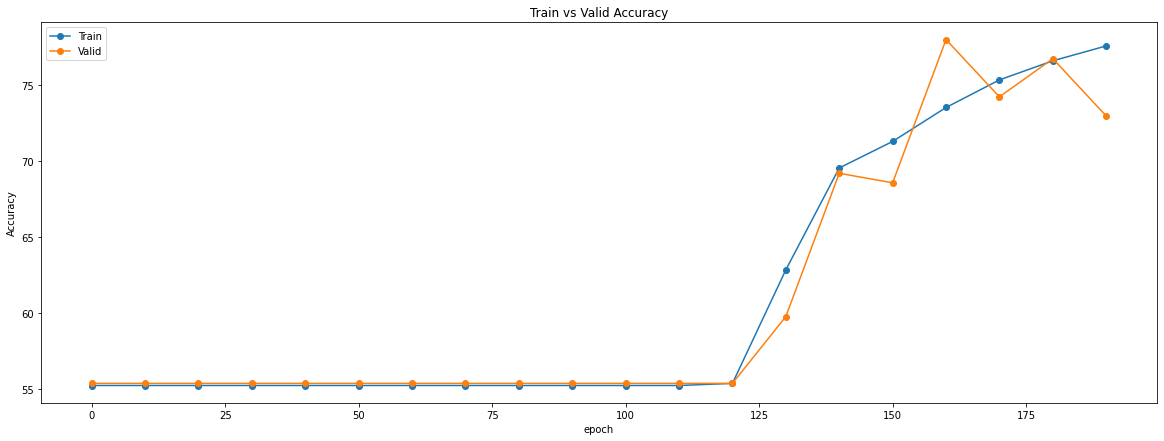

In [42]:
graph(loss_abc, 200,10,'train_acc', 'val_acc','Accuracy','Accuracy')

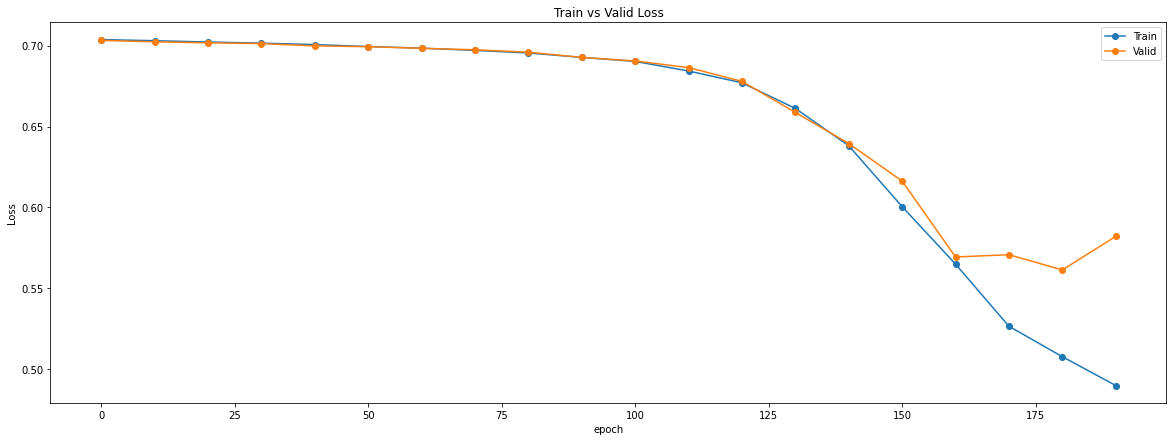

In [43]:
graph(loss_abc, 200,10,'train_loss', 'val_loss','Loss','Loss')

In [44]:
# compute the loss & accuracy on the test set using the best available model
checkpoint = torch.load("Glove.h5")
classifier.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
classifier.eval()

# classifier.load_state_dict(torch.load(train_state['model_filename']))
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('test')

batch_generator = generate_batches(dataset, batch_size=len(dataset), device=args.device)
running_loss = 0.
running_acc = 0.

classifier.eval()
for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred =  classifier(batch_dict['x_data'])
    
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

In [45]:
print("Test loss: {};".format(train_state['test_loss']))
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 0.5233663320541382;
Test Accuracy: 74.87437185929649


## Overview

In [47]:
# Best score we got
data = {'Train Loss':[0.217,0.402],
        'Train Acc':[94.6191,84.3466],
       'Val Loss':[0.5522,0.5657],
       'Val Acc':[76.7296,76.1006],
       'Test loss':[0.584, 0.5255],
       'Test Accuracy':[74.12,76.3820]}

df = pd.DataFrame(data, index =['Feed-forward Neural Network','Conv1d based model'])
df

,Train Loss,Train Acc,Val Loss,Val Acc,Test loss,Test Accuracy
Feed-forward Neural Network,0.217,94.6191,0.5522,76.7296,0.5840,74.120
Conv1d based model,0.402,84.3466,0.5657,76.1006,0.5255,76.382


In regards to performance, CNN Conv1d based model performs slighty better than Feed-forward Neural Network model. This can be seen on the table above by comparing the respective models test accuracy and test loss. It can be seen that the CNN model performs slightly more accurate and has a lower loss rate. 


## Bonus | HyperParamter Tuning

The results for the following models are recorded at the end of the notebook. 

For the Covn1d Model, i used the following hyperparameters to test if the model would perform better:

#### 1. Number of Hidden layers: 
the model was tested with 2, 4 and 6 convolution layers. Oddly, the performance with 2 convolution layers produced the highest test accuracy. 

#### 2. Activation Function 
The CNN model was tested with three activation functions: relu, selu and elu. 

#### 3. Kernal Size 
For the CNN model the kernal size that were passed through the CNN model were three and five. 

#### 4. Drop Out Rate
Different drop out rate have been utulised to regularise the CNN model in order to prevent the model from overfitting

#### 5. Batch Normalisation 
Another regularisation technique that  normalizes the output of a previous layer.

#### 6. Pooling
The following pooling methods: Average Pooling Layer and Max Pooling Layer are utilised to summarise and retains the important details of the image. 


### Model 2

The model was tested with the ELU activation function.

In [ ]:
# class GloveClassifier(nn.Module):
#     def __init__(self, embedding_size, num_embeddings, num_channels, hidden_dim, num_classes, dropout_p, pretrained_embeddings=None, padding_idx=0):
#         super(GloveClassifier, self).__init__()

#         if pretrained_embeddings is None:
#             self.emb = nn.Embedding(embedding_dim=embedding_size, num_embeddings=num_embeddings, padding_idx=padding_idx)        
#         else:
#             pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
#             self.emb = nn.Embedding(embedding_dim=embedding_size, num_embeddings=num_embeddings, padding_idx=padding_idx,      _weight=pretrained_embeddings)
            
#         self.convnet = nn.Sequential(
#             nn.Conv1d(in_channels=embedding_size, out_channels=num_channels[0], kernel_size=3, stride=1),
#             nn.ELU(),
#             nn.Conv1d(in_channels=num_channels[0], out_channels=num_channels[1], kernel_size=2, stride=1),
#             nn.ELU(),
#             nn.Conv1d(in_channels=num_channels[1], out_channels=num_channels[2], kernel_size=3, stride=1),
#             nn.ELU(),
#             nn.Conv1d(in_channels=num_channels[2], out_channels=num_channels[3], kernel_size=2),
#             nn.ELU()
#         )
#         #MLP         
#         self._dropout_p = dropout_p
#         self.fc1 = nn.Linear(num_channels[3], hidden_dim[0])
#         self.elu1 = nn.ELU()
#         self.dropout1 = nn.Dropout(0.1)
        
#         self.fc2 = nn.Linear(hidden_dim[0], hidden_dim[1])
#         self.elu2 = nn.ELU()
        
#         self.fc3 = nn.Linear(hidden_dim[1], num_classes)

#     def forward(self, x_in, apply_softmax=False):
#         # embed and permute so features are channels
#         x_embedded = self.emb(x_in).permute(0, 2, 1)
#         features = self.convnet(x_embedded)
#         # average and remove the extra dimension
#         remaining_size = features.size(dim=2)
#         features = nn.functional.max_pool1d(features, remaining_size).squeeze(dim=2)
#         features = nn.functional.dropout(features, p=self._dropout_p)
        
#         out = self.fc1(features)
#         out = self.elu1(out)
#         out = self.dropout1(out)
        
#         out = self.fc2(out)
#         out = self.elu2(out)
        
#         out = self.fc3(out)

#         if apply_softmax:
#             out = torch.nn.functional.softmax(out, dim=1)
#         return out

### Model 3

The model was tested with the Selu activation function.

In [ ]:
# class GloveClassifier(nn.Module):
#     def __init__(self, embedding_size, num_embeddings, num_channels, hidden_dim, num_classes, dropout_p, pretrained_embeddings=None, padding_idx=0):
#         super(GloveClassifier, self).__init__()

#         if pretrained_embeddings is None:
#             self.emb = nn.Embedding(embedding_dim=embedding_size, num_embeddings=num_embeddings, padding_idx=padding_idx)        
#         else:
#             pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
#             self.emb = nn.Embedding(embedding_dim=embedding_size, num_embeddings=num_embeddings, padding_idx=padding_idx,      _weight=pretrained_embeddings)
            
#         self.convnet = nn.Sequential(
#             nn.Conv1d(in_channels=embedding_size, out_channels=num_channels[0], kernel_size=3, stride=1),
#             nn.SELU(),
#             nn.Conv1d(in_channels=num_channels[0], out_channels=num_channels[1], kernel_size=2, stride=1),
#             nn.SELU(),
#             nn.Conv1d(in_channels=num_channels[1], out_channels=num_channels[2], kernel_size=3, stride=1),
#             nn.SELU(),
#             nn.Conv1d(in_channels=num_channels[2], out_channels=num_channels[3], kernel_size=2),
#             nn.SELU()
#         )
#         #MLP         
#         self._dropout_p = dropout_p
#         self.fc1 = nn.Linear(num_channels[3], hidden_dim[0])
#         self.selu1 = nn.SELU()
#         self.dropout1 = nn.Dropout(0.1)
        
#         self.fc2 = nn.Linear(hidden_dim[0], hidden_dim[1])
#         self.selu2 = nn.SELU()
        
#         self.fc3 = nn.Linear(hidden_dim[1], num_classes)

#     def forward(self, x_in, apply_softmax=False):
#         # embed and permute so features are channels
#         x_embedded = self.emb(x_in).permute(0, 2, 1)
#         features = self.convnet(x_embedded)
#         # average and remove the extra dimension
#         remaining_size = features.size(dim=2)
#         features = nn.functional.max_pool1d(features, remaining_size).squeeze(dim=2)
#         features = nn.functional.dropout(features, p=self._dropout_p)
        
#         out = self.fc1(features)
#         out = self.selu1(out)
#         out = self.dropout1(out)
        
#         out = self.fc2(out)
#         out = self.selu2(out)
        
#         out = self.fc3(out)

#         if apply_softmax:
#             out = torch.nn.functional.softmax(out, dim=1)
#         return out

### Model 4

The model was tested with 6 Conv1d layers

In [ ]:
# class GloveClassifier(nn.Module):
#     def __init__(self, embedding_size, num_embeddings, num_channels, hidden_dim, num_classes, dropout_p, pretrained_embeddings=None, padding_idx=0):
#         super(GloveClassifier, self).__init__()

#         if pretrained_embeddings is None:
#             self.emb = nn.Embedding(embedding_dim=embedding_size, num_embeddings=num_embeddings, padding_idx=padding_idx)        
#         else:
#             pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
#             self.emb = nn.Embedding(embedding_dim=embedding_size, num_embeddings=num_embeddings, padding_idx=padding_idx,      _weight=pretrained_embeddings)
            
#         self.convnet = nn.Sequential(
#             nn.Conv1d(in_channels=embedding_size, out_channels=num_channels[0], kernel_size=3, stride=1),
#             nn.ReLU(),
#             nn.Conv1d(in_channels=num_channels[0], out_channels=num_channels[1], kernel_size=2, stride=1),
#             nn.ReLU(),
#             nn.Conv1d(in_channels=num_channels[1], out_channels=num_channels[2], kernel_size=3, stride=1),
#             nn.ReLU(),
#             nn.Conv1d(in_channels=num_channels[2], out_channels=num_channels[3], kernel_size=2),
#             nn.ReLU(),
#             nn.Conv1d(in_channels=num_channels[3], out_channels=num_channels[4], kernel_size=3, stride=1),
#             nn.ReLU(),
#             nn.Conv1d(in_channels=num_channels[4], out_channels=num_channels[5], kernel_size=2),
#             nn.ReLU()
#         )
#         #MLP         
#         self._dropout_p = dropout_p
#         self.fc1 = nn.Linear(num_channels[5], hidden_dim[0])
#         self.relu1 = nn.ReLU()
#         self.dropout1 = nn.Dropout(0.1)
        
#         self.fc2 = nn.Linear(hidden_dim[0], hidden_dim[1])
#         self.relu2 = nn.ReLU()
        
#         self.fc3 = nn.Linear(hidden_dim[1], num_classes)

#     def forward(self, x_in, apply_softmax=False):
#         # embed and permute so features are channels
#         x_embedded = self.emb(x_in).permute(0, 2, 1)
#         features = self.convnet(x_embedded)
#         # average and remove the extra dimension
#         remaining_size = features.size(dim=2)
#         features = nn.functional.max_pool1d(features, remaining_size).squeeze(dim=2)
#         features = nn.functional.dropout(features, p=self._dropout_p)
        
#         out = self.fc1(features)
#         out = self.relu1(out)
#         out = self.dropout1(out)
        
#         out = self.fc2(out)
#         out = self.relu2(out)
        
#         out = self.fc3(out)

#         if apply_softmax:
#             out = torch.nn.functional.softmax(out, dim=1)
#         return out

In [ ]:
# classifier = GloveClassifier(
#     embedding_size=embedding_size, 
#     num_embeddings=len(vectorizer.NARRATIVE_vocab),
#     num_channels=[512, 256, 128, 64, 32, 32],
#     hidden_dim=[32, 16], 
#     num_classes=len(vectorizer.target_vocab), 
#     dropout_p=0.3,
#     pretrained_embeddings=embeddings,
#     padding_idx=0
# )
# if not torch.cuda.is_available():
#     args.cuda = False
# args.device = torch.device("cuda" if args.cuda else "cpu")

### Model 5

The model was tested with 2 conv1d layers

In [ ]:
# class GloveClassifier(nn.Module):
#     def __init__(self, embedding_size, num_embeddings, num_channels, hidden_dim, num_classes, dropout_p, pretrained_embeddings=None, padding_idx=0):
#         super(GloveClassifier, self).__init__()

#         if pretrained_embeddings is None:
#             self.emb = nn.Embedding(embedding_dim=embedding_size, num_embeddings=num_embeddings, padding_idx=padding_idx)        
#         else:
#             pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
#             self.emb = nn.Embedding(embedding_dim=embedding_size, num_embeddings=num_embeddings, padding_idx=padding_idx,  _weight=pretrained_embeddings)
            
#         self.convnet = nn.Sequential(
#             nn.Conv1d(in_channels=embedding_size, out_channels=num_channels[0], kernel_size=3, stride=1),
#             nn.ReLU(),
#             nn.Conv1d(in_channels=num_channels[0], out_channels=num_channels[1], kernel_size=2, stride=1),
#             nn.ReLU()
#         )
#         #MLP         
#         self._dropout_p = dropout_p
#         self.fc1 = nn.Linear(num_channels[1], hidden_dim[0])
#         self.relu1 = nn.ReLU()
#         self.dropout1 = nn.Dropout(0.1)
        
#         self.fc2 = nn.Linear(hidden_dim[0], hidden_dim[1])
#         self.relu2 = nn.ReLU()
        
#         self.fc3 = nn.Linear(hidden_dim[1], num_classes)

#     def forward(self, x_in, apply_softmax=False):
#         # embed and permute so features are channels
#         x_embedded = self.emb(x_in).permute(0, 2, 1)
#         features = self.convnet(x_embedded)
#         # average and remove the extra dimension
#         remaining_size = features.size(dim=2)
#         features = nn.functional.max_pool1d(features, remaining_size).squeeze(dim=2)
#         features = nn.functional.dropout(features, p=self._dropout_p)
        
#         out = self.fc1(features)
#         out = self.relu1(out)
#         out = self.dropout1(out)
        
#         out = self.fc2(out)
#         out = self.relu2(out)
        
#         out = self.fc3(out)

#         if apply_softmax:
#             out = torch.nn.functional.softmax(out, dim=1)
#         return out

### Model 6

Used avg_pool1d instead of max_pool1d

In [ ]:
# class GloveClassifier(nn.Module):
#     def __init__(self, embedding_size, num_embeddings, num_channels, hidden_dim, num_classes, dropout_p, pretrained_embeddings=None, padding_idx=0):
#         super(GloveClassifier, self).__init__()

#         if pretrained_embeddings is None:
#             self.emb = nn.Embedding(embedding_dim=embedding_size, num_embeddings=num_embeddings, padding_idx=padding_idx)        
#         else:
#             pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
#             self.emb = nn.Embedding(embedding_dim=embedding_size, num_embeddings=num_embeddings, padding_idx=padding_idx,      _weight=pretrained_embeddings)
            
#         self.convnet = nn.Sequential(
#             nn.Conv1d(in_channels=embedding_size, out_channels=num_channels[0], kernel_size=3, stride=1),
#             nn.ReLU(),
#             nn.Conv1d(in_channels=num_channels[0], out_channels=num_channels[1], kernel_size=2, stride=1),
#             nn.ReLU(),
#             nn.Conv1d(in_channels=num_channels[1], out_channels=num_channels[2], kernel_size=3, stride=1),
#             nn.ReLU(),
#             nn.Conv1d(in_channels=num_channels[2], out_channels=num_channels[3], kernel_size=2, stride=1),
#             nn.ReLU()
#         )
#         #MLP         
#         self._dropout_p = dropout_p
#         self.fc1 = nn.Linear(num_channels[3], hidden_dim[0])
#         self.relu1 = nn.ReLU()
#         self.dropout1 = nn.Dropout(0.1)
        
#         self.fc2 = nn.Linear(hidden_dim[0], hidden_dim[1])
#         self.relu2 = nn.ReLU()
        
#         self.fc3 = nn.Linear(hidden_dim[1], num_classes)

#     def forward(self, x_in, apply_softmax=False):
#         # embed and permute so features are channels
#         x_embedded = self.emb(x_in).permute(0, 2, 1)
#         features = self.convnet(x_embedded)
#         # average and remove the extra dimension
#         remaining_size = features.size(dim=2)
#         features = nn.functional.avg_pool1d(features, remaining_size).squeeze(dim=2)
#         features = nn.functional.dropout(features, p=self._dropout_p)
        
#         out = self.fc1(features)
#         out = self.relu1(out)
#         out = self.dropout1(out)
        
#         out = self.fc2(out)
#         out = self.relu2(out)
        
#         out = self.fc3(out)

#         if apply_softmax:
#             out = torch.nn.functional.softmax(out, dim=1)
#         return out

### Model 7

Used different kernal size

In [ ]:
# class GloveClassifier(nn.Module):
#     def __init__(self, embedding_size, num_embeddings, num_channels, hidden_dim, num_classes, dropout_p, pretrained_embeddings=None, padding_idx=0):
#         super(GloveClassifier, self).__init__()

#         if pretrained_embeddings is None:
#             self.emb = nn.Embedding(embedding_dim=embedding_size, num_embeddings=num_embeddings, padding_idx=padding_idx)        
#         else:
#             pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
#             self.emb = nn.Embedding(embedding_dim=embedding_size, num_embeddings=num_embeddings, padding_idx=padding_idx,      _weight=pretrained_embeddings)
            
#         self.convnet = nn.Sequential(
#             nn.Conv1d(in_channels=embedding_size, out_channels=num_channels[0], kernel_size=5, stride=1),
#             nn.ReLU(),
#             nn.Conv1d(in_channels=num_channels[0], out_channels=num_channels[1], kernel_size=4, stride=1),
#             nn.ReLU(),
#             nn.Conv1d(in_channels=num_channels[1], out_channels=num_channels[2], kernel_size=5, stride=1),
#             nn.ReLU(),
#             nn.Conv1d(in_channels=num_channels[2], out_channels=num_channels[3], kernel_size=4),
#             nn.ReLU()
#         )
#         #MLP         
#         self._dropout_p = dropout_p
#         self.fc1 = nn.Linear(num_channels[3], hidden_dim[0])
#         self.relu1 = nn.ReLU()
#         self.dropout1 = nn.Dropout(0.1)
        
#         self.fc2 = nn.Linear(hidden_dim[0], hidden_dim[1])
#         self.relu2 = nn.ReLU()
        
#         self.fc3 = nn.Linear(hidden_dim[1], num_classes)

#     def forward(self, x_in, apply_softmax=False):
#         # embed and permute so features are channels
#         x_embedded = self.emb(x_in).permute(0, 2, 1)
#         features = self.convnet(x_embedded)
#         # average and remove the extra dimension
#         remaining_size = features.size(dim=2)
#         features = nn.functional.max_pool1d(features, remaining_size).squeeze(dim=2)
#         features = nn.functional.dropout(features, p=self._dropout_p)
        
#         out = self.fc1(features)
#         out = self.relu1(out)
#         out = self.dropout1(out)
        
#         out = self.fc2(out)
#         out = self.relu2(out)
        
#         out = self.fc3(out)

#         if apply_softmax:
#             out = torch.nn.functional.softmax(out, dim=1)
#         return out

### Model 8

Inlusion of batch normalisation

In [ ]:
# class GloveClassifier(nn.Module):
#     def __init__(self, embedding_size, num_embeddings, num_channels, hidden_dim, num_classes, dropout_p, pretrained_embeddings=None, padding_idx=0):
#         super(GloveClassifier, self).__init__()

#         if pretrained_embeddings is None:
#             self.emb = nn.Embedding(embedding_dim=embedding_size, num_embeddings=num_embeddings, padding_idx=padding_idx)        
#         else:
#             pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
#             self.emb = nn.Embedding(embedding_dim=embedding_size, num_embeddings=num_embeddings, padding_idx=padding_idx,      _weight=pretrained_embeddings)
        
        
#         self.conv1 = nn.Sequential(
#             nn.Conv1d(in_channels=embedding_size, out_channels=num_channels[0], kernel_size=3, stride=1),
#             nn.BatchNorm1d(num_channels[0]),
#             nn.ReLU() 
#         )
        
#         self.conv2 = nn.Sequential(
#             nn.Conv1d(in_channels=num_channels[0], out_channels=num_channels[1], kernel_size=2, stride=1),
#             nn.BatchNorm1d(num_channels[1]),
#             nn.ReLU()
#         )
            
#         self.conv3 = nn.Sequential(
#             nn.Conv1d(in_channels=num_channels[1], out_channels=num_channels[2], kernel_size=3, stride=1),
#             nn.BatchNorm1d(num_channels[2]),
#             nn.ReLU()
#         )

#         self.conv4 = nn.Sequential(
#             nn.Conv1d(in_channels=num_channels[2], out_channels=num_channels[3], kernel_size=3, stride=1),
#             nn.BatchNorm1d(num_channels[3]),
#             nn.ReLU()
#         )
        
#         #MLP         
       
#         self._dropout_p = dropout_p
#         self.fc1 = nn.Linear(num_channels[3], hidden_dim[0])
#         self.relu1 = nn.ReLU()
#         self.dropout1 = nn.Dropout(0.1)
        
#         self.fc2 = nn.Linear(hidden_dim[0], hidden_dim[1])
#         self.relu2 = nn.ReLU()
        
#         self.fc3 = nn.Linear(hidden_dim[1], num_classes)

        
#     def forward(self, x_in, apply_softmax=False):
#         # embed and permute so features are channels
#         x_embedded = self.emb(x_in).permute(0, 2, 1)
#         features = self.conv1(x_embedded)
#         features = self.conv2(features)
#         features = self.conv3(features)
#         features = self.conv4(features)
        
        
#         remaining_size = features.size(dim=2)
#         features = nn.functional.max_pool1d(features, remaining_size).squeeze(dim=2)
#         features = nn.functional.dropout(features, p=self._dropout_p)
        
#         out = self.fc1(features)
#         out = self.relu1(out)
#         out = self.dropout1(out)
        
#         out = self.fc2(out)
#         out = self.relu2(out)
        
#         out = self.fc3(out)



#         if apply_softmax:
#             out = torch.nn.functional.softmax(out, dim=1)
#         return out

### Model 9

In [ ]:
# class GloveClassifier(nn.Module):
#     def __init__(self, embedding_size, num_embeddings, num_channels, hidden_dim, num_classes, dropout_p, pretrained_embeddings=None, padding_idx=0):
#         super(GloveClassifier, self).__init__()

#         if pretrained_embeddings is None:
#             self.emb = nn.Embedding(embedding_dim=embedding_size, num_embeddings=num_embeddings, padding_idx=padding_idx)        
#         else:
#             pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
#             self.emb = nn.Embedding(embedding_dim=embedding_size, num_embeddings=num_embeddings, padding_idx=padding_idx,      _weight=pretrained_embeddings)
        
#         self.convnet = nn.Sequential(
#             nn.Conv1d(in_channels=embedding_size, out_channels=num_channels[0], kernel_size=3, stride=1),
#             nn.ReLU(),
#             nn.Conv1d(in_channels=num_channels[0], out_channels=num_channels[1], kernel_size=2, stride=1),
#             nn.ReLU(),
#             nn.Conv1d(in_channels=num_channels[1], out_channels=num_channels[2], kernel_size=3, stride=1),
#             nn.ReLU(),
#             nn.Conv1d(in_channels=num_channels[2], out_channels=num_channels[3], kernel_size=2),
#             nn.BatchNorm1d(num_channels[3]),
#             nn.ReLU()
#         )
        
#         #MLP         
       
#         self._dropout_p = dropout_p
#         self.fc1 = nn.Linear(num_channels[3], hidden_dim[0])
#         self.relu1 = nn.ReLU()
#         self.dropout1 = nn.Dropout(0.1)
        
#         self.fc2 = nn.Linear(hidden_dim[0], hidden_dim[1])
#         self.relu2 = nn.ReLU()
        
#         self.fc3 = nn.Linear(hidden_dim[1], num_classes)


#     def forward(self, x_in, apply_softmax=False):
#         # embed and permute so features are channels
#         x_embedded = self.emb(x_in).permute(0, 2, 1)
#         features = self.convnet(x_embedded)
#         # average and remove the extra dimension
#         remaining_size = features.size(dim=2)
#         features = nn.functional.max_pool1d(features, remaining_size).squeeze(dim=2)
#         features = nn.functional.dropout(features, p=self._dropout_p)
        
#         out = self.fc1(features)
# #         out = nn.functional.dropout(out, p=self._dropout_p)
#         out = self.relu1(out)
#         out = self.dropout1(out)
        
#         out = self.fc2(out)
#         out = self.relu2(out)
        
#         out = self.fc3(out)

#         if apply_softmax:
#             out = torch.nn.functional.softmax(out, dim=1)
#         return out

### Model 10

Different drop out rate

In [ ]:
# class GloveClassifier(nn.Module):
#     def __init__(self, embedding_size, num_embeddings, num_channels, hidden_dim, num_classes, dropout_p, pretrained_embeddings=None, padding_idx=0):
#         super(GloveClassifier, self).__init__()

#         if pretrained_embeddings is None:
#             self.emb = nn.Embedding(embedding_dim=embedding_size, num_embeddings=num_embeddings, padding_idx=padding_idx)        
#         else:
#             pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
#             self.emb = nn.Embedding(embedding_dim=embedding_size, num_embeddings=num_embeddings, padding_idx=padding_idx,      _weight=pretrained_embeddings)
            
#         self.convnet = nn.Sequential(
#             nn.Conv1d(in_channels=embedding_size, out_channels=num_channels[0], kernel_size=3, stride=1),
#             nn.ReLU(),
#             nn.Conv1d(in_channels=num_channels[0], out_channels=num_channels[1], kernel_size=2, stride=1),
#             nn.ReLU(),
#             nn.Conv1d(in_channels=num_channels[1], out_channels=num_channels[2], kernel_size=3, stride=1),
#             nn.ReLU(),
#             nn.Conv1d(in_channels=num_channels[2], out_channels=num_channels[3], kernel_size=2),
#             nn.ReLU()
#         )
#         #MLP         
#         self._dropout_p = dropout_p
#         self.fc1 = nn.Linear(num_channels[3], hidden_dim[0])
#         self.relu1 = nn.ReLU()
#         self.dropout1 = nn.Dropout(0.5)
        
#         self.fc2 = nn.Linear(hidden_dim[0], hidden_dim[1])
#         self.relu2 = nn.ReLU()
        
#         self.fc3 = nn.Linear(hidden_dim[1], num_classes)

#     def forward(self, x_in, apply_softmax=False):
#         # embed and permute so features are channels
#         x_embedded = self.emb(x_in).permute(0, 2, 1)
#         features = self.convnet(x_embedded)
#         # average and remove the extra dimension
#         remaining_size = features.size(dim=2)
#         features = nn.functional.max_pool1d(features, remaining_size).squeeze(dim=2)
#         features = nn.functional.dropout(features, p=self._dropout_p)
        
#         out = self.fc1(features)
#         out = self.relu1(out)
#         out = self.dropout1(out)
        
#         out = self.fc2(out)
#         out = self.relu2(out)
        
#         out = self.fc3(out)

#         if apply_softmax:
#             out = torch.nn.functional.softmax(out, dim=1)
#         return out

### Model 11

In [ ]:
# class GloveClassifier(nn.Module):
#     def __init__(self, embedding_size, num_embeddings, num_channels, hidden_dim, num_classes, dropout_p, pretrained_embeddings=None, padding_idx=0):
#         super(GloveClassifier, self).__init__()

#         if pretrained_embeddings is None:
#             self.emb = nn.Embedding(embedding_dim=embedding_size, num_embeddings=num_embeddings, padding_idx=padding_idx)        
#         else:
#             pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
#             self.emb = nn.Embedding(embedding_dim=embedding_size, num_embeddings=num_embeddings, padding_idx=padding_idx,      _weight=pretrained_embeddings)
            
#         self.convnet = nn.Sequential(
#             nn.Conv1d(in_channels=embedding_size, out_channels=num_channels[0], kernel_size=3, stride=1),
#             nn.ReLU(),
#             nn.Conv1d(in_channels=num_channels[0], out_channels=num_channels[1], kernel_size=2, stride=1),
#             nn.ReLU(),
#             nn.Conv1d(in_channels=num_channels[1], out_channels=num_channels[2], kernel_size=3, stride=1),
#             nn.ReLU(),
#             nn.Conv1d(in_channels=num_channels[2], out_channels=num_channels[3], kernel_size=2),
#             nn.ReLU()
#         )
#         #MLP         
#         self._dropout_p = dropout_p
#         self.fc1 = nn.Linear(num_channels[3], hidden_dim[0])
#         self.relu1 = nn.ReLU()
#         self.dropout1 = nn.Dropout(0.1)
        
#         self.fc2 = nn.Linear(hidden_dim[0], num_classes)

#     def forward(self, x_in, apply_softmax=False):
#         # embed and permute so features are channels
#         x_embedded = self.emb(x_in).permute(0, 2, 1)
#         features = self.convnet(x_embedded)
#         # average and remove the extra dimension
#         remaining_size = features.size(dim=2)
#         features = nn.functional.max_pool1d(features, remaining_size).squeeze(dim=2)
#         features = nn.functional.dropout(features, p=self._dropout_p)
        
#         out = self.fc1(features)
#         out = self.relu1(out)
#         out = self.dropout1(out)
        
#         out = self.fc2(out)


#         if apply_softmax:
#             out = torch.nn.functional.softmax(out, dim=1)
#         return out

### Model 12


In [ ]:
# class GloveClassifier(nn.Module):
#     def __init__(self, embedding_size, num_embeddings, num_channels, hidden_dim, num_classes, dropout_p, pretrained_embeddings=None, padding_idx=0):
#         super(GloveClassifier, self).__init__()

#         if pretrained_embeddings is None:
#             self.emb = nn.Embedding(embedding_dim=embedding_size, num_embeddings=num_embeddings, padding_idx=padding_idx)        
#         else:
#             pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
#             self.emb = nn.Embedding(embedding_dim=embedding_size, num_embeddings=num_embeddings, padding_idx=padding_idx,      _weight=pretrained_embeddings)
            
#         self.convnet = nn.Sequential(
#             nn.Conv1d(in_channels=embedding_size, out_channels=num_channels[0], kernel_size=3, stride=1),
#             nn.ReLU(),
#             nn.Conv1d(in_channels=num_channels[0], out_channels=num_channels[1], kernel_size=2, stride=1),
#             nn.ReLU(),
#             nn.MaxPool1d(1),
#             nn.Dropout(0.1),
#             nn.Conv1d(in_channels=num_channels[1], out_channels=num_channels[2], kernel_size=3, stride=1),
#             nn.ReLU(),
#             nn.Conv1d(in_channels=num_channels[2], out_channels=num_channels[3], kernel_size=2),
#             nn.ReLU(),
#             nn.Dropout(0.1)
#         )
#         #MLP         
#         self._dropout_p = dropout_p
#         self.fc1 = nn.Linear(num_channels[3], hidden_dim[0])
#         self.relu1 = nn.ReLU()
#         self.dropout1 = nn.Dropout(0.1)
        
#         self.fc2 = nn.Linear(hidden_dim[0], hidden_dim[1])
#         self.relu2 = nn.ReLU()
        
#         self.fc3 = nn.Linear(hidden_dim[1], num_classes)

#     def forward(self, x_in, apply_softmax=False):
#         # embed and permute so features are channels
#         x_embedded = self.emb(x_in).permute(0, 2, 1)
#         features = self.convnet(x_embedded)
#         # average and remove the extra dimension
#         remaining_size = features.size(dim=2)
#         features = nn.functional.max_pool1d(features, remaining_size).squeeze(dim=2)
#         features = nn.functional.dropout(features, p=self._dropout_p)
        
#         out = self.fc1(features)
#         out = self.relu1(out)
#         out = self.dropout1(out)
        
#         out = self.fc2(out)
#         out = self.relu2(out)
        
#         out = self.fc3(out)

#         if apply_softmax:
#             out = torch.nn.functional.softmax(out, dim=1)
#         return out

### Hypertuning Performance

Each model above is distinct from on another, whether it be in terms of hyperparameter tuning or changing the structure of the model. The aim of this tuning was to see if we could improve the performance of the model, and the results from those models are captured below. 

In [40]:
data = {'Train Loss':[0.3732,0.3288,0.2122,0.2963,0.4435,0.5651,0.3302,0.0917,0.1741,0.4555,0.3584,0.4694],
        'Train Acc':[85.5346,86.6527,94.7589,89.1684,81.5514,72.956,88.0503,99.3012,96.5758,80.6429,85.9539,82.949],
       'Val Loss':[0.5673,0.6093,0.6116,0.6444,0.5315,0.57,0.6133,0.6596,0.6429,0.581,0.5321,0.6647],
       'Val Acc':[76.7296,71.0692,74.8428,76.1006,73.5849,71.6981,78.6164,72.327,72.956,71.0692,77.9874,63.522],
       'Test loss':[0.5058,0.5455,0.5577,0.6377,0.5050,0.5411,0.5482,0.6553,0.5683,0.4932,0.5405,0.5947],
       'Test Accuracy':[75.8794,74.1206,76.1307,72.3618,77.1357,73.8693,74.6231,69.09548,72.11056,77.8894,76.1307,71.8592]}


df = pd.DataFrame(data, index =['Model 1',
                                'Model 2',
                                'Model 3',
                                'Model 4',
                                'Model 5',
                                'Model 6',
                                'Model 7',
                                'Model 8',
                                'Model 9',
                                'Model 10',
                                'Model 11',
                                'Model 12'])
df

,Train Loss,Train Acc,Val Loss,Val Acc,Test loss,Test Accuracy
Model 1,0.3732,85.5346,0.5673,76.7296,0.5058,75.87940
Model 2,0.3288,86.6527,0.6093,71.0692,0.5455,74.12060
Model 3,0.2122,94.7589,0.6116,74.8428,0.5577,76.13070
Model 4,0.2963,89.1684,0.6444,76.1006,0.6377,72.36180
Model 5,0.4435,81.5514,0.5315,73.5849,0.5050,77.13570
Model 6,0.5651,72.9560,0.5700,71.6981,0.5411,73.86930
Model 7,0.3302,88.0503,0.6133,78.6164,0.5482,74.62310
Model 8,0.0917,99.3012,0.6596,72.3270,0.6553,69.09548
Model 9,0.1741,96.5758,0.6429,72.9560,0.5683,72.11056
Model 10,0.4555,80.6429,0.5810,71.0692,0.4932,77.88940


In terms of performance, we found that Model 10 had the best overall performance as it gave the best Test Accuracy and Test Loss. Out of all the tests, the Model 10 was the model with a higher drop out rate. This means that increasing the level from 0.1 and 0.5 lead the model to peform better.  

There were models (such as model 8, model 9, model 3) producing a train accuracy close to 100%, meaning that the models are overfitting the data as a train accuracy close to 100% is very unlikely. 